# NLP Super Stars --  A Natural Language Processing Project
Jared Vahle, Joshua Bryant, Hector Rodriguez, Sarah Lawson Woods - November 2021

In [1]:
import requests
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pprint import pprint

from wordcloud import WordCloud
from modeling import *

import os
import json

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from prepare import *

import nltk
import nltk.sentiment

import warnings


In [2]:
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Acquire

In [3]:
# pulling in the data from a json that included all the readme's in the repo list
data = pd.read_json('data.json')

In [4]:
# taking a look at the contents
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


### Acquire Takeaway
- The data was acquired by scaping the starred repos on GitHub number 1001-1009 and then 10010-10060; we chose these specific repos in order to avoid the first ones that mostly included guides and some unfinished products, we also wanted to make sure we had some variety so we pulled some that were further down the list.
- We brought in 506 rows initially 

# Prepare

In [5]:
# Let's check for missing values in the language column
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [6]:
# removed languages that were 'none'
data = data.dropna()

In [7]:
len(data)

506

In [8]:
# Let's see what values we have for each type of language
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Shell                13
Swift                13
HTML                 12
Rust                 11
Kotlin                9
Ruby                  9
C#                    9
PHP                   6
Vue                   6
Jupyter Notebook      6
Vim script            6
CSS                   5
Objective-C           3
Lua                   2
TeX                   2
Haskell               2
CoffeeScript          2
Elixir                2
Emacs Lisp            1
OCaml                 1
Crystal               1
Standard ML           1
Dart                  1
AsciiDoc              1
Rascal                1
Makefile              1
Dockerfile            1
Clojure               1
Batchfile             1
Name: language, dtype: int64

In [9]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [10]:
# Check out the number of repos we will be examining
len(data)

357

### Language Counts

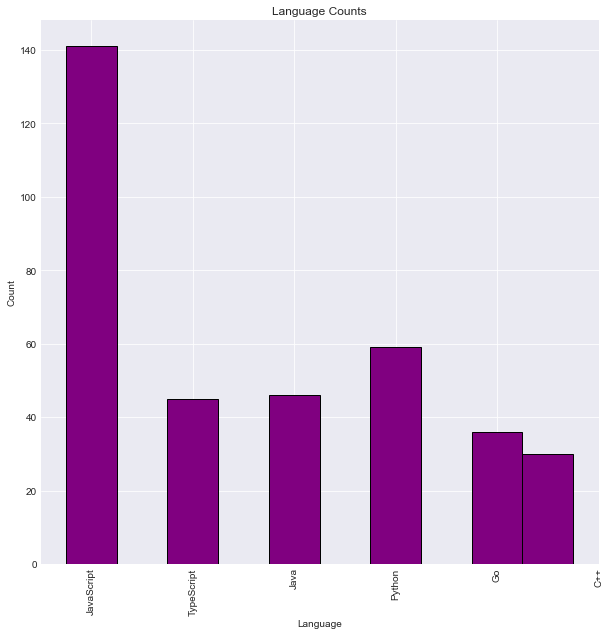

In [11]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'left', color = 'purple', ec = 'k')
plt.title('Language Counts')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Here we checked to make sure all of the null values were removed above by our drop 
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [13]:
# Next we use our prep function that takes in a df and the string name for a text column with the option to 
# pass lists for extra_words and exclude_words and returns a df with the readme text, original text and stemmed 
# text, lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

In [14]:
# At this point we dropped the original contents since we had it in all the forms we need for exploration and 
# modeling
data = data.drop(columns = ['readme_contents'])

In [15]:
# This function gives us message length, word count and average word length added as columns to the df
data = get_columns(data)

In [16]:
# Here we made a column named is_javascript to hold all rows that the language column indicated were javascript
data['is_javascript'] = data.apply(lambda row: is_javascript(row), axis=1)

In [17]:
# And here we made a column named sentiment to tell us the aggregate sentiment of the 
# text of each readme
data['sentiment'] = data.clean.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [18]:
# Taking a look at the modified data
data

,repo,language,clean,stemmed,lemmatized,message_length,word_count,avg_word_length,is_javascript,sentiment
3,tailwindlabs/tailwindcss,JavaScript,utilityfirst cs framework rapidly building cus...,utilityfirst cs framework rapidli build custom...,utilityfirst c framework rapidly building cust...,549,48,11.437500,True,0.9349
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...,1882,209,9.004785,True,0.8481
7,ianstormtaylor/slate,TypeScript,completely customizable framework building ric...,complet customiz framework build rich text edi...,completely customizable framework building ric...,7461,718,10.391365,False,0.9986
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,3120,311,10.032154,True,0.8720
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,2027,74,27.391892,False,0.9729
...,...,...,...,...,...,...,...,...,...,...
551,TheAlgorithms/Java,Java,httpsgithubcomthealgorithmsjavatreedevelopment...,httpsgithubcomthealgorithmsjavatreedevelop jav...,httpsgithubcomthealgorithmsjavatreedevelopment...,4485,243,18.456790,False,0.0000
555,tornadoweb/tornado,Python,tornado web server image httpsbadgesgitterimjo...,tornado web server imag httpsbadgesgitterimjoi...,tornado web server image httpsbadgesgitterimjo...,911,92,9.902174,False,0.6808
557,gulpjs/gulp,JavaScript,streaming build system npm versionnpmimagenpmu...,stream build system npm versionnpmimagenpmurl ...,streaming build system npm versionnpmimagenpmu...,6677,734,9.096730,True,0.9963
558,alibaba/weex,C++,weex framework building mobile crossplatform u...,weex framework build mobil crossplatform ui bu...,weex framework building mobile crossplatform u...,807,43,18.767442,False,0.6124


### Takeaways
- In the stage of the pipeline we checked for null values and dropped all rows missing a value in the language column since we had more than enough rows without the 54 that we ended up dropping here
- We then looked at the value counts for each language and decided to drop all the languages that contained less than 30 readme's because we didnt want there to be a problem stratifying the sparse languages in each section of the split dataset
- The next step was to use our prep function stored in the prepare file that takes in a df and the string name for a text column with the option to pass lists for extra_words and exclude_words and returns a df with the readme text, cleaned text, stemmed text, lemmatized text, with stopwords removed from all columns.
- Next we removed the readme_contents column since we had no more use for it in explore or modeling
- We then used the get_columns function to give us message length, word count and average word length added as columns to the df
- We also created two columns named is_javascript to hold all rows that the language column indicated were javascript and a sentiment column to tell us the aggregate sentiment of the text of each readme


# Explore 

- We know that JavaScript makes up near 40% of the readme with the other 60% being non JavaScript

In [19]:
# Let's look at the language of each readme by percentage
data.language.value_counts(normalize = True)

JavaScript    0.394958
Python        0.165266
Java          0.128852
TypeScript    0.126050
Go            0.100840
C++           0.084034
Name: language, dtype: float64

In [20]:
# Taking a lookt at the number of readme's by language after the modifications in prepare
data.language.value_counts()

JavaScript    141
Python         59
Java           46
TypeScript     45
Go             36
C++            30
Name: language, dtype: int64

In [21]:
# Displaying the index dtype and columns, non-null values and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 3 to 559
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   repo             357 non-null    object 
 1   language         357 non-null    object 
 2   clean            357 non-null    object 
 3   stemmed          357 non-null    object 
 4   lemmatized       357 non-null    object 
 5   message_length   357 non-null    int64  
 6   word_count       357 non-null    int64  
 7   avg_word_length  355 non-null    float64
 8   is_javascript    357 non-null    bool   
 9   sentiment        357 non-null    float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 28.2+ KB


In [22]:
# Generate descriptive statistics
data.describe()

,message_length,word_count,avg_word_length,sentiment
count,357.000000,357.000000,355.000000,357.000000
mean,8929.117647,829.109244,11.917034,0.819141
std,17912.084390,1612.111164,4.654157,0.412686
min,0.000000,0.000000,5.849530,-0.995700
25%,2336.000000,194.000000,9.107213,0.927400
50%,4041.000000,364.000000,10.483871,0.989000
75%,7300.000000,734.000000,13.129932,0.996400
max,141410.000000,13110.000000,41.034483,1.000000


In [23]:
# combine all messages in single string by label
JavaScript_words = clean(' '.join(data[data.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(data[data.language == 'Python'].stemmed))
TS_words = clean(' '.join(data[data.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(data[data.language == 'Java'].stemmed))
Go_words = clean(' '.join(data[data.language == 'Go'].stemmed))
C_words = clean(' '.join(data[data.language == 'C++'].stemmed))
Non_JavaScript = clean(' '.join(data[data.language != 'JavaScript'].stemmed))
all_words = clean(' '.join(data.stemmed))

In [24]:
# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [25]:
# Looking at the frequency of word that appeared in the TypeScript readme
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

use                                                                                             318
const                                                                                           168
react                                                                                           131
redux                                                                                           126
function                                                                                        121
                                                                                               ... 
natur                                                                                             1
herepackagesangularclireadmemd                                                                    1
downloadshttpsimgshieldsionpmdmreactreduxsvgstyleflatsquarehttpswwwnpmjscompackagereactredux      1
fhefh2015github1schromeextensionhttpsgithubcomfhefh2015github1schromeextens                       1


In [26]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
non_JavaScript_freq = pd.Series(Non_JavaScript.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [27]:
# Created a dataframe of the word frequencies as they occurred above to include grand totals
word_counts = pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq,non_JavaScript_freq, all_words_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['javascript','python','java','go','c','ts','NonJS','all']
word_counts.head()

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
javascript,837,42,3,1,2,58,106,943
code,792,209,94,65,71,77,516,1308
function,790,151,19,43,82,121,416,1206
j,772,7,2,7,48,94,158,930


In [28]:
# Here we put them in order from highest to lowest occurrences by total count in the all column
word_counts.sort_values('all', ascending = False).head(20)

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
file,705,526,54,166,109,38,893,1598
instal,480,568,49,141,125,103,986,1466
code,792,209,94,65,71,77,516,1308
support,478,325,124,99,117,91,756,1234
function,790,151,19,43,82,121,416,1206
project,672,160,97,51,54,92,454,1126
1,353,339,74,113,137,89,752,1105
option,578,360,16,66,27,38,507,1085
run,418,254,89,117,64,86,610,1028


In [75]:
# Then we just sorted by NonJS and javascript columns only
word_counts.sort_values(['NonJS','javascript'],ascending = [True,False]).head(20)


,javascript,python,java,go,c,ts,NonJS,all
exampl,371,185,43,67,56,79,430,801
list,185,263,20,73,26,48,430,615
set,370,213,36,82,49,66,446,816
project,672,160,97,51,54,92,454,1126
command,213,295,30,95,24,32,476,689
see,290,213,72,97,70,41,493,783
2,238,226,63,37,98,76,500,738
option,578,360,16,66,27,38,507,1085
code,792,209,94,65,71,77,516,1308
version,432,251,73,72,81,63,540,972


In [76]:
# Here we sorted by javascript and then NonJS
word_counts.sort_values(['javascript','NonJS'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
get,387,138,39,62,45,80,364,751
run,418,254,89,117,64,86,610,1028
default,419,169,27,95,42,40,373,792
api,424,56,38,38,22,70,224,648
version,432,251,73,72,81,63,540,972
return,450,129,16,54,48,91,338,788
support,478,325,124,99,117,91,756,1234
instal,480,568,49,141,125,103,986,1466
const,541,4,0,0,67,168,239,780
new,543,179,44,24,97,80,424,967


## Top 20

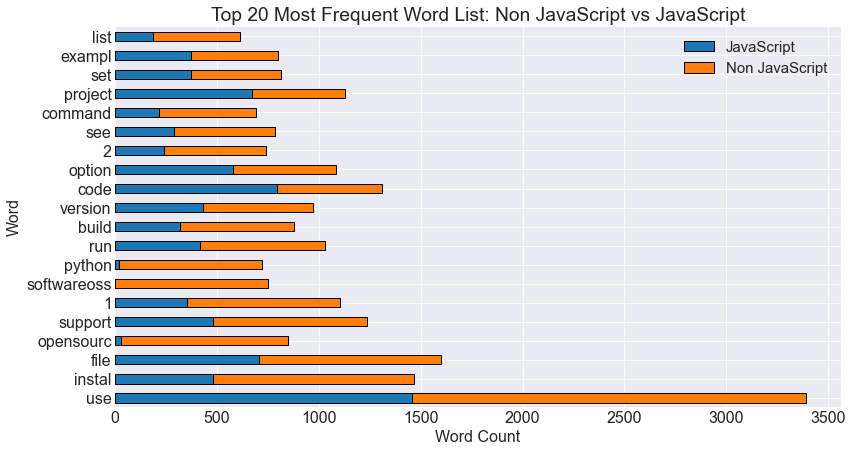

In [31]:
# Displayed the 20 most frequent word list by Non Javascript vs JavaScript
plt.rc('font', size=16)
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: Non JavaScript vs JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

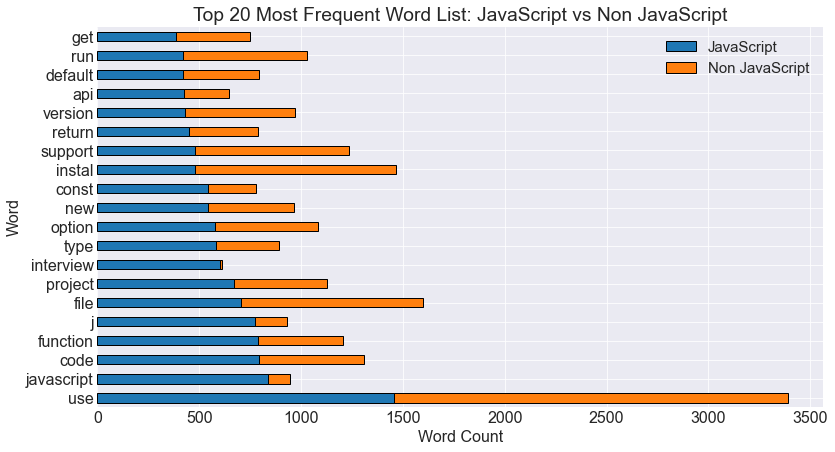

In [32]:
# Displayed the 20 most frequent word list by Javascript vs Non JavaScript
plt.rc('font', size=16)
word_counts.sort_values('javascript', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: JavaScript vs Non JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

## Top 20 Distribution

<Figure size 1152x648 with 0 Axes>

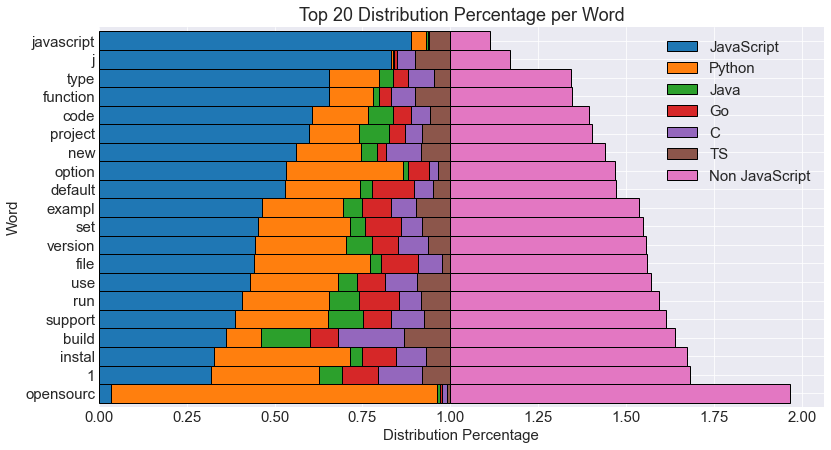

In [78]:
# Plotted the distribution percentages per word by language
plt.figure(figsize=(16, 9))
plt.rc('font', size=15)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('Top 20 Distribution Percentage per Word')
plt.xlabel('Distribution Percentage')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Python', 'Java', 'Go', 'C', 'TS', 'Non JavaScript'])
plt.show()

## Bigrams

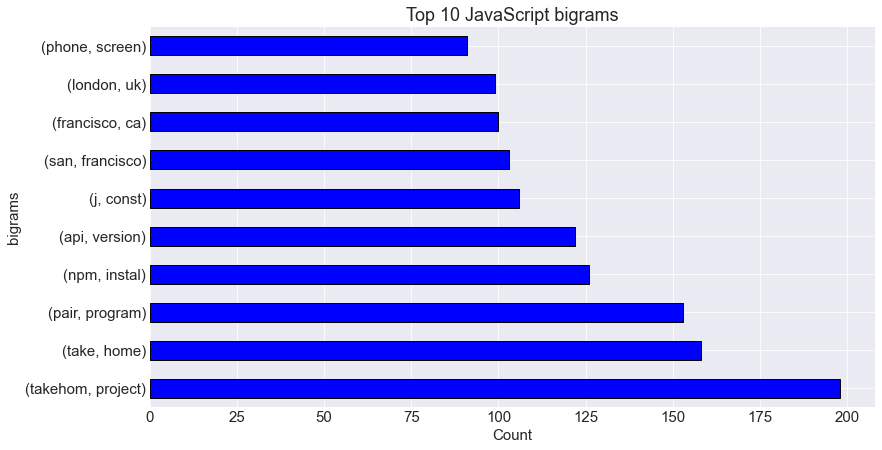

In [77]:
# Plotted the top 10 JavaScript bigrams
pd.Series(nltk.bigrams(JavaScript_words.split())).value_counts().head(10).plot.barh(color = 'blue',ec = 'k')
plt.title('Top 10 JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

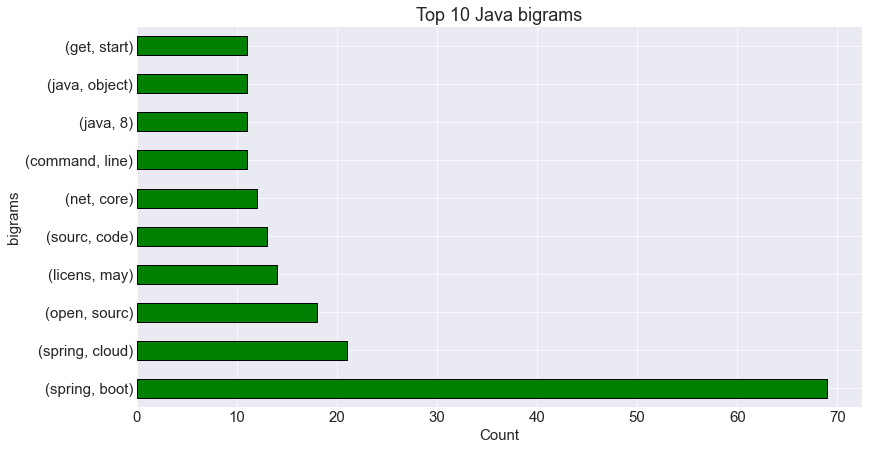

In [79]:
# Displaying the top Java bigrams
pd.Series(nltk.bigrams(Java_words.split())).value_counts().head(10).plot.barh(color = 'green',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Java bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

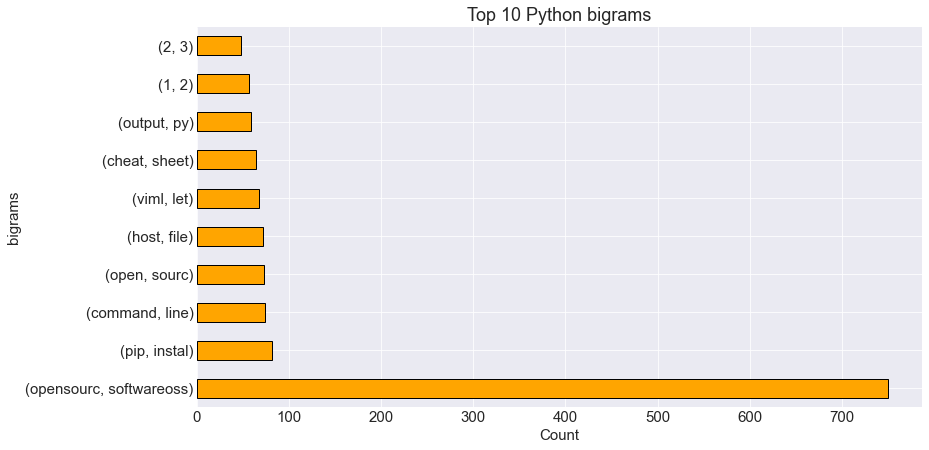

In [80]:
# Plotting the top 10 bigrams
pd.Series(nltk.bigrams(Python_words.split())).value_counts().head(10).plot.barh(color = 'orange',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Python bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

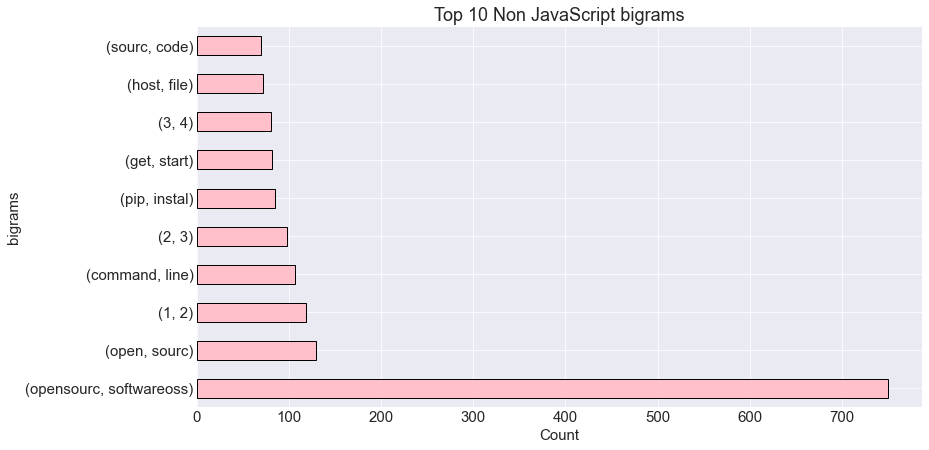

In [82]:
# Displaying the top 10 Non JavaScipt bigrams
pd.Series(nltk.bigrams(Non_JavaScript.split())).value_counts().head(10).plot.barh(color = 'pink',ec = 'k')
plt.title('Top 10 Non JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

## Clouds

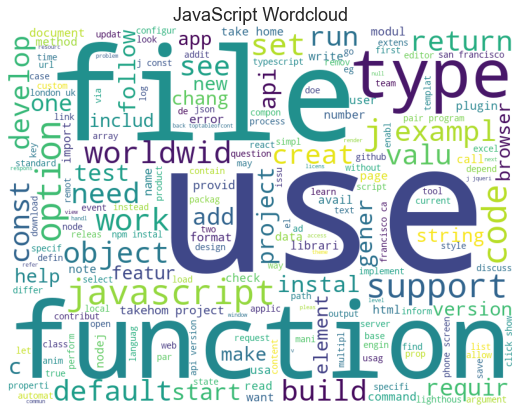

In [87]:
# Creating a wordcloud for JavaScript words
img = WordCloud(background_color='white', width=800, height=600).generate(JavaScript_words)
plt.title('JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

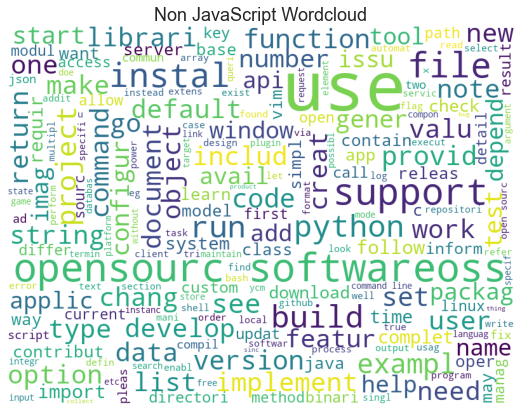

In [85]:
# Displaying a Non JavaScript wordcloud
img = WordCloud(background_color='white', width=800, height=600).generate(Non_JavaScript)
plt.title('Non JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

## Relational Plots

### Language Relationships

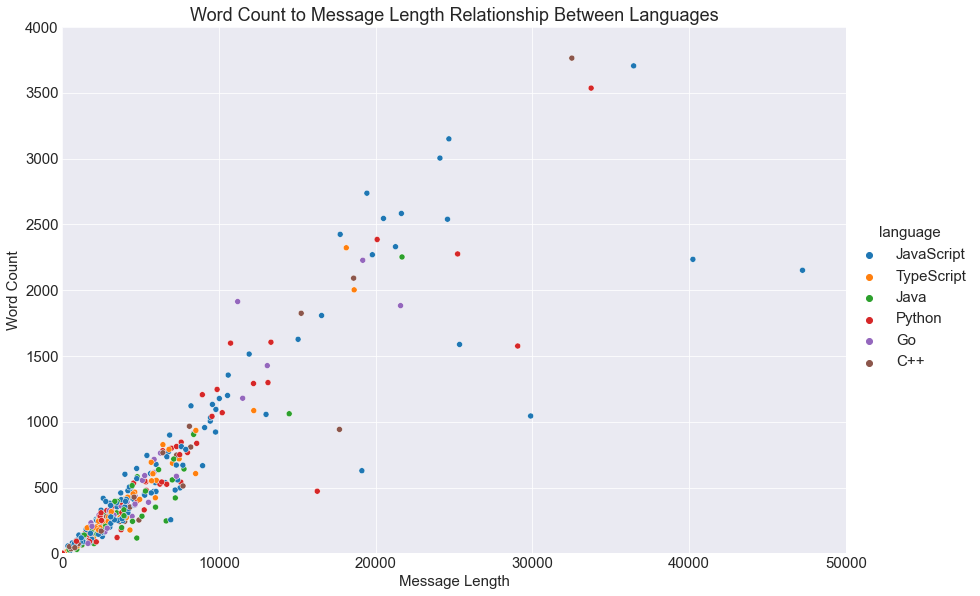

In [88]:
# Created a relpot to display word count to message length relationship between languages
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Language Narrowed in Limits

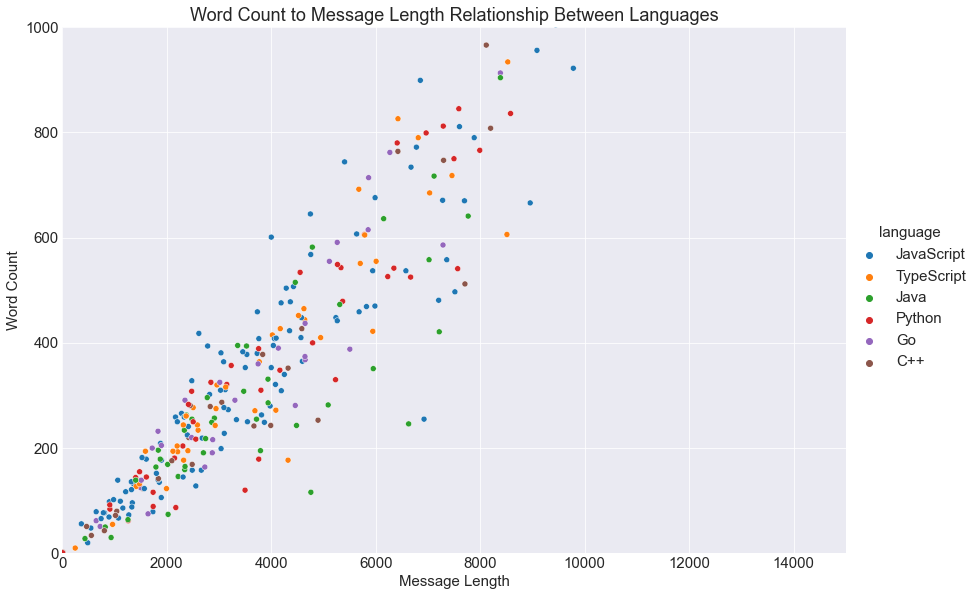

In [89]:
# A closer look at the above visualization
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### JavaScript Relationships

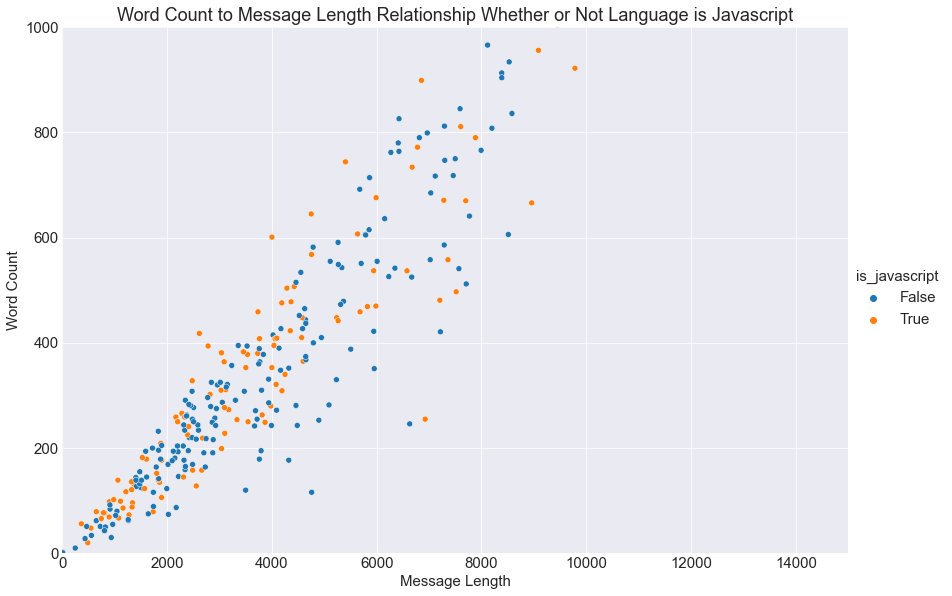

In [90]:
# Creating a relplot to display word count to message length relationship whether or not language is Javascript
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Is_JavaScript Narrowed in limits

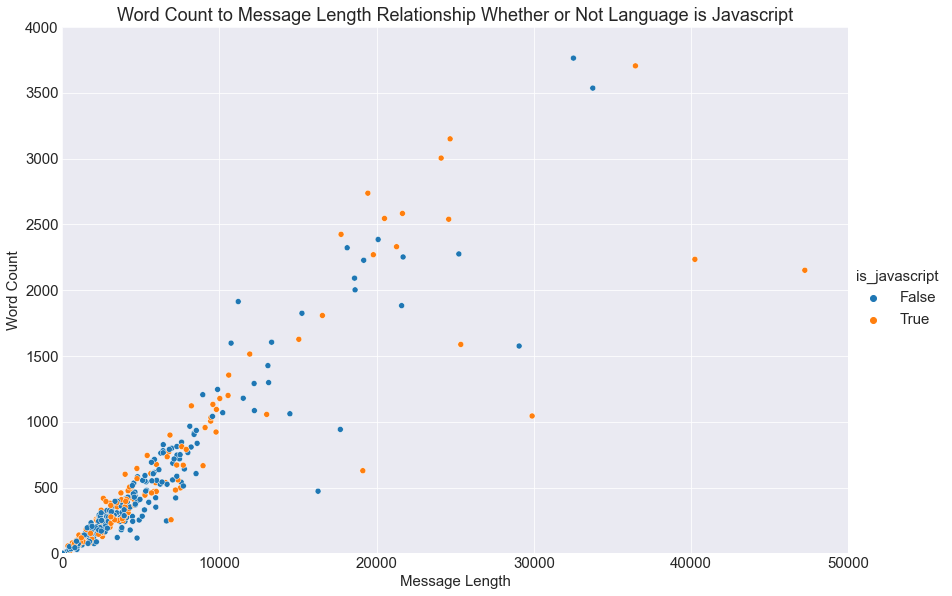

In [91]:
# A closer look at the above visualization
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### Average Word Relationships

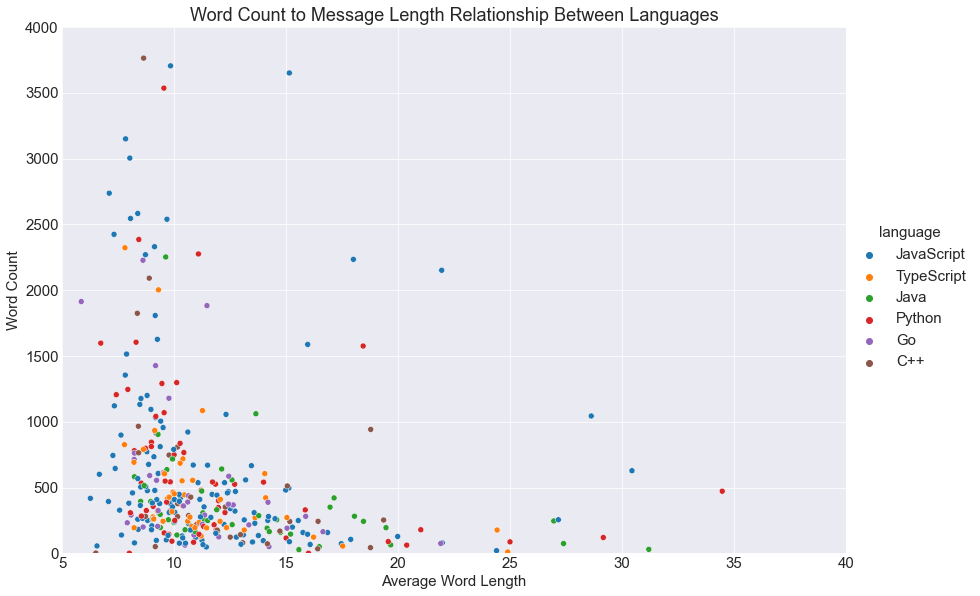

In [92]:
# Creating a replot of word count to message length with a hue of languages
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(5,40))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

#### Average Narrowed in Limits

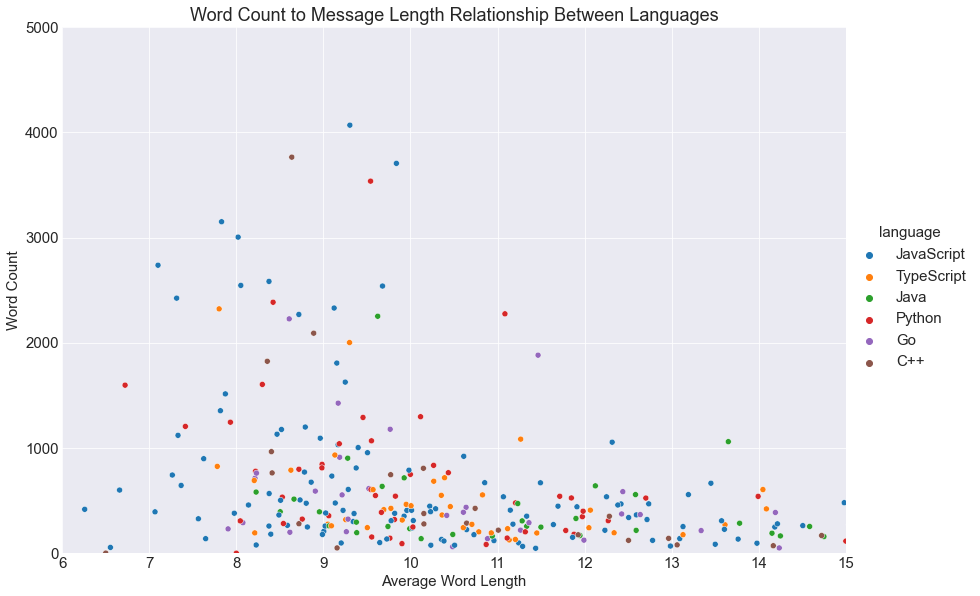

In [93]:
# Creating a relplot of word count to message length with a hue of languages
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 5000))
plot.set(xlim=(6,15))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

In [46]:
# Here we displayed the median and mean of message length, word count and sentiment in a df
data.groupby('language')['message_length','word_count','sentiment'].agg(['mean','median'])

message_length          word_count        sentiment         
                     mean median         mean median      mean   median
language                                                               
C++           7950.300000   3754   779.633333    280  0.857807  0.98710
Go            9014.944444   4299   761.805556    364  0.733331  0.98955
Java          7136.369565   3417   457.326087    256  0.670570  0.96590
JavaScript    9918.340426   4095   950.808511    408  0.869337  0.99030
Python       11676.101695   5336  1179.101695    525  0.786159  0.98880
TypeScript    4644.422222   3772   455.777778    316  0.899844  0.99150

In [47]:
# Next we grouped by whether or not they were Javascript or not
data.groupby('is_javascript').agg(['mean','median'])

message_length         word_count        avg_word_length  \
                        mean median        mean median            mean   
is_javascript                                                            
False            8283.375000   3940  749.666667    323       12.256531   
True             9918.340426   4095  950.808511    408       11.401769   

                         sentiment          
                  median      mean  median  
is_javascript                               
False          10.723922  0.786374  0.9874  
True           10.032154  0.869337  0.9903

## Sentiment Values

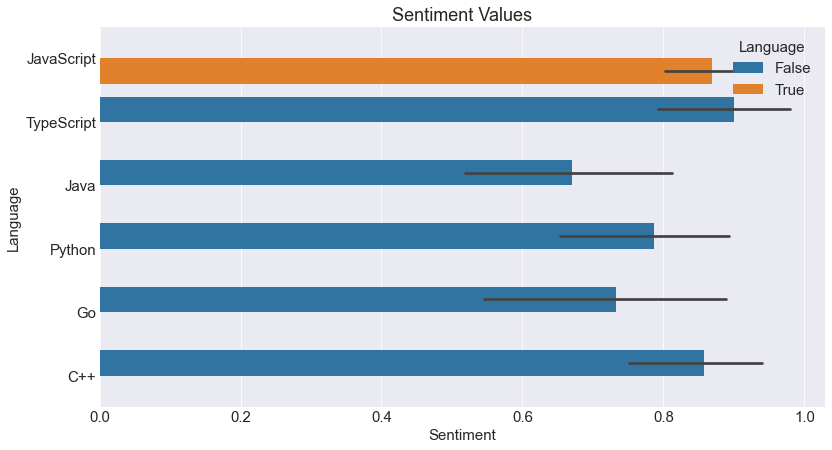

In [95]:
# This is plot of the compound aggregate sentiment by language
sns.barplot(data = data, x = 'sentiment', y = 'language', hue = 'is_javascript')
plt.title('Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Language')
plt.legend(loc = 'upper right', title = 'Language')
plt.show()

### Takeways
- We know that JavaScript makes up near 40% of the readme's with the other 60% being non JavaScript
JS takes up 40%
Top 5 JS - git, run, default, api, version
Top 5 Non JS - list, example, set, project, command
Top JS bigrams are (phone,  screen), (London, UK), (Fransico, CA)
Top NJS bigrams are (sour, code), (host, file), (3, 4)
JS Wordclouds top 3 use, file, function 
NJS wc t3 most common ‘use’
Language relations real-lot meaning
Average word length
AVG JS is 950
Avg NJS is 749

# Modeling

In [49]:
# Bag of words
cv = CountVectorizer()
bag_of_words = cv.fit_transform(data.clean)

In [50]:
bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [51]:
pprint(data)

                                      repo    language  \
3                 tailwindlabs/tailwindcss  JavaScript   
5                             github/fetch  JavaScript   
7                     ianstormtaylor/slate  TypeScript   
8                            Kong/insomnia  JavaScript   
9    CymChad/BaseRecyclerViewAdapterHelper        Java   
..                                     ...         ...   
551                     TheAlgorithms/Java        Java   
555                     tornadoweb/tornado      Python   
557                            gulpjs/gulp  JavaScript   
558                           alibaba/weex         C++   
559                           dmlc/xgboost         C++   

                                                 clean  \
3    utilityfirst cs framework rapidly building cus...   
5    windowfetch polyfill fetch function promisebas...   
7    completely customizable framework building ric...   
8    insomnia rest client slack channelhttpschatins...   
9    httpsuse

In [52]:
# TFIDF 
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(data.clean)

pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names()).sample(20)

,00,000,0000,00000,000000,00000001,0000001,00008384,0001,0001two,...,zxingcpprbhttpsgithubcomglassechidnazxingcpprb,zxingjslibraryhttpsgithubcomzxingjslibrary,zxingobjchttpsgithubcomthelevelupzxingobjc,zxingorg,zyclotropj,zyclotropjhttpsgithubcomzyclotropj,zyedidiamicro,zypehttpsboardsgreenhouseiozype,zypper,zyte
260,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058391,0.058391,0.058391,0.116782,0.0,0.0,0.0,0.0,0.0,0.0
286,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
325,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
137,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
265,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
345,0.0,0.0,0.037147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

use                   1.363080
using                 1.482370
support               1.509895
project               1.552657
code                  1.557523
                        ...   
fluxutils             6.187386
flvjs                 6.187386
flvminjs              6.187386
flutter929dart1031    6.187386
zyte                  6.187386
Length: 57624, dtype: float64

In [54]:
data.is_javascript.value_counts(normalize = True)

False    0.605042
True     0.394958
Name: is_javascript, dtype: float64

In [55]:
# Baseline: ~60.5

In [56]:
# Using Clean, Stemmed, lemmatized data on a MultinomialNB, and DecisionTreeClassifier.

In [57]:
# Getting the cleaned data
X = data.clean
y = data.is_javascript

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [58]:
# Cleaned data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_clean)

clf.score(X_bow, y_train_clean)

1.0

In [59]:
# Cleaned data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_clean)

clf.score(X_tfidf, y_train_clean)

1.0

In [60]:
# Cleaned data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_clean)

tree.score(X_bow, y_train_clean)

0.9298245614035088

In [61]:
# Cleaned data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
tree.fit(X_tfidf,y_train_clean)
tree.score(X_tfidf,y_train_clean)

0.9438596491228071

In [62]:
# Getting the stemmed data
X = data.stemmed
y = data.is_javascript

X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [63]:
# Stemmed data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_stemmed)

clf.score(X_bow, y_train_stemmed)

1.0

In [64]:
# Stemmed data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_stemmed)

clf.score(X_tfidf, y_train_stemmed)

1.0

In [65]:
# Stemmed data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_stemmed)

tree.score(X_bow, y_train_stemmed)

0.9263157894736842

In [66]:
# Stemmed data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
tree.fit(X_tfidf,y_train_stemmed)
tree.score(X_tfidf,y_train_stemmed)

0.9473684210526315

In [67]:
# Getting the lemmatized data
X = data.lemmatized
y = data.is_javascript

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [68]:
# Lemmatized data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_lemmatized)

clf.score(X_bow, y_train_lemmatized)

1.0

In [69]:
# Lemmatized data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_lemmatized)

clf.score(X_tfidf, y_train_lemmatized)

1.0

In [70]:
# Lemmatized data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_lemmatized)

tree.score(X_bow, y_train_lemmatized)

0.9298245614035088

In [71]:
# Lemmatized data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
tree.fit(X_tfidf,y_train_lemmatized)
tree.score(X_tfidf,y_train_lemmatized)

0.9438596491228071

In [72]:
tree.score(tfidf.transform(X_test_clean), y_test_clean)

0.7222222222222222

In [73]:
predictions = make_predictions(clf,X_train_clean,X_test_clean,y_train_clean)

In [74]:
# uses count vectorization on the cleaned data and makes a model report on the test predictions using a multinomialNB
model_report(y_test_clean, predictions)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|   Positive Case: is javascript = 'false'    |
|   Negative Case: is javascript = 'true'     |
|---------------------------------------------|
|                 Accuracy:   77.78%          |
|       True Positive Rate:   56.25%          |
|      False Positive Rate:   33.93%          |
|       True Negative Rate:   66.07%          |
|      False Negative Rate:   43.75%          |
|                Precision:   73.08%          |
|                   Recall:   67.86%          |
|                 F1-Score:   70.37%          |
|                                             |
|         Positive Support:       28          |
|         Negative Support:       44          |
|            Total Support:       72          |
|_____________________________________________|



### Takeaways
- Waiting for Jared and Joshua's input

# Conclusion

In [ ]:
Questions and Comments
I think we need to do the baseline on train
Is this the correct method to find baseline?
Is it ok to move the split to prepare
Write out the explore takeaways
